In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6 

from moSlicer import MoSlicer
import moMetrics as mm
import moSummaryMetrics as ms
import moPlots as moPlots
import moMetricBundle as mmb
import lsst.sims.maf.plots as plots

/Users/lynnej/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Define data set and generic metadata.
orbitfile = 'pha20141031.des'
testDir = 'kraken_1039_pha20141031'
obsfile = os.path.join(testDir, 'pha20141031_allObs.txt')
runName = testDir.replace('_pha20141031', '')
metadata = 'MPC PHAs'

In [3]:
# Read orbit and observation data into a moving object slicer.
mos = MoSlicer(orbitfile, Hrange=np.arange(15, 26, 0.5))
mos.readObs(obsfile)

In [4]:
summaryMetrics = [ms.CompletenessMetric(), ms.CumulativeCompletenessMetric()]

In [5]:
# Set up a metric bundle to identify discovery (and then calculate completeness)
# Calculate this for a variety of years.
discbundles = {}
extrapairbundles = {}
longdiscbundles = {}
magicbundles = {}
velocitybundles = {}
nyears = [5, 10, 12, 15]
for yr in nyears:
    # 'normal' discovery conditions - 3 pairs in 15 nights.
    metric = mm.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                        nNightsPerWindow=3, tWindow=15)
    slicer = mos
    constraint = 'night < %d' %(yr * 365 + 1)
    md = metadata + ' year %d, 3 pairs in 15 nights' %(yr)
    plotDict = {'nxbins':200, 'nybins':200, 'albedo':0.07}
    discbundles[yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                        runName=runName, metadata=md, 
                                        plotDict=plotDict, summaryMetrics=summaryMetrics)
    # 'extra pair' discovery conditions - 4 pairs in 20 nights.
    metric = mm.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2, 
                                      nNightsPerWindow=4, tWindow=20)
    md = metadata + ' year %d, 4 pairs in 20 nights' %(yr)
    extrapairbundles[yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                             runName=runName, metadata=md, 
                                             plotDict=plotDict, summaryMetrics=summaryMetrics)
    # 'long' discovery window - 3 pairs in 30 nights.
    metric = mm.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2,
                                      nNightsPerWindow=3, tWindow=30)
    md = metadata + ' year %d, 3 pairs in 30 nights' %(yr)
    longdiscbundles[yr] = mmb.MoMetricBundle(metric, slicer, constraint, 
                                             runName=runName, metadata=md, 
                                             plotDict=plotDict, summaryMetrics=summaryMetrics)
    # 'magic' discoveries - 6 visits within 30 nights
    metric = mm.MagicDiscoveryMetric(nObs=6, tWindow=60)
    md = metadata + ' year %d, 6 obs in 60 nights' %(yr)
    magicbundles[yr] = mmb.MoMetricBundle(metric, slicer, constraint,
                                         runName=runName, metadata=md,
                                         plotDict=plotDict, summaryMetrics=summaryMetrics)
    # discoveries via high velocity - more than 1deg/day
    metric = mm.HighVelocityMetric(velocity=1.0)
    md = metadata + ' year %d, velocity>1deg/day' %(yr)
    velocitybundles[yr] = mmb.MoMetricBundle(metric, slicer, constraint,
                                         runName=runName, metadata=md,
                                         plotDict=plotDict, summaryMetrics=summaryMetrics)

In [6]:
# In year twelve only, look at discovery as function of SNR
snrbundles = {}
snrList = [4, 5, 5.5, 6, 7]
for snr in snrList:
    metric = mm.DiscoveryChancesMetric(tNight=90./60./24., nObsPerNight=2,
                                      nNightsPerWindow=3, tWindow=15, snrLimit=snr)
    slicer = mos
    constraint = 'night < %d' %(12*365+1)
    md = metadata + ' year %d, SNR=%.1f' %(yr, snr)
    snrbundles[snr] = mmb.MoMetricBundle(metric, slicer, constraint,
                                         runName=runName, metadata=md,
                                         plotDict=plotDict, summaryMetrics=summaryMetrics)

In [7]:
# Combine all the bundles above into one big dictionary.
bdict = {}
count = 0
for md in [discbundles, extrapairbundles, longdiscbundles, magicbundles, velocitybundles, snrbundles]:
    for mb in md.itervalues():
        bdict[count] = mb
        count += 1
print bdict.keys()
print bdict[24].metadata

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
MPC PHAs year 15, SNR=7.0 night < 4381


In [8]:
# Run all the metricbundles. This will take a while - we're computing lots of things. 
bg = mmb.MoMetricBundleGroup(bdict, outDir=testDir)
bg.runAll()

Calculated all metrics.


In [9]:
bg.summaryAll()

In [10]:
ph = plots.PlotHandler(outDir=testDir, savefig=True)
# Will use a mock metricBundle to generate plots. 
# The completeness values (what we typically want to plot here) are a summary value, not an actual metric value.
# So this little bit of fiddling lets us use the plotHandler as we would normally (with a metricBundle), but with 
# the actual values we want to plot. 
yearColors = {5:'r', 10:'g', 12:'b', 15:'y'}
snrColors = {4:'r', 5:'b', 5.5:'y', 6:'g', 7:'k'}

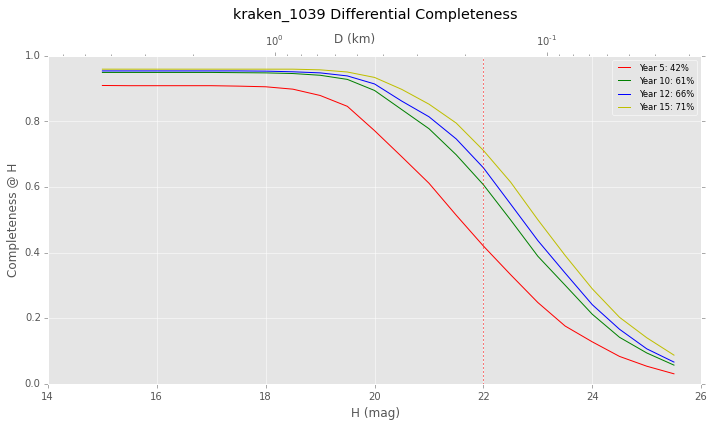

In [11]:
# Differential completeness, as function of H (for each of nyear above)
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = discbundles[yr].summaryValues['Completeness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Differential Completeness' %(runName), 'ylabel':'Completeness @ H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')

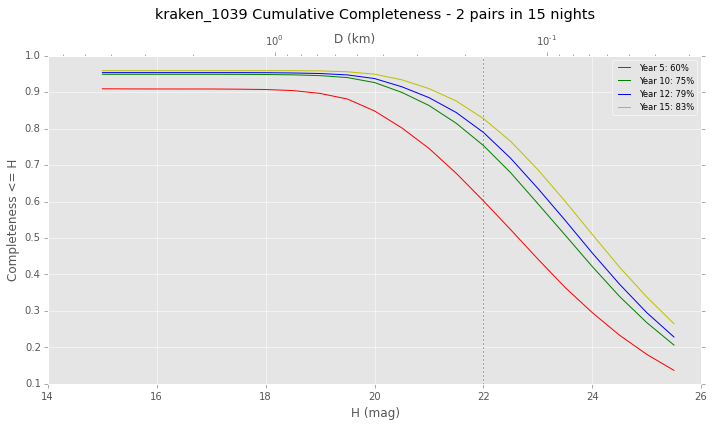

In [12]:
# Cumulative completeness, as function of H (for each of nyear above)
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = discbundles[yr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Cumulative Completeness - 2 pairs in 15 nights' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')

# ph.plot(plotFunc=moPlots.MetricVsOrbit(), plotDicts={'Hval':22})

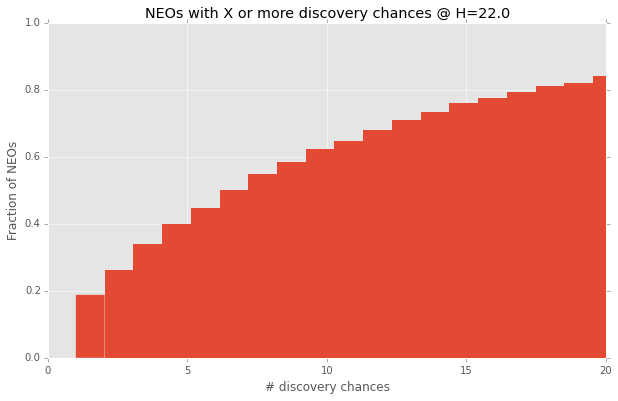

In [13]:
# Histogram of discovery chances at a given H, in year 12 standard discovery.
b = discbundles[12]
mVals = b.metricValues.swapaxes(0, 1)[Hidx].filled(0)
plt.hist(mVals[np.where(mVals>0)], bins=100, cumulative=True, normed=True, edgecolor='none')
plt.xlabel('# discovery chances')
plt.ylabel('Fraction of NEOs')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('NEOs with X or more discovery chances @ H=%.1f' %(Hmark))

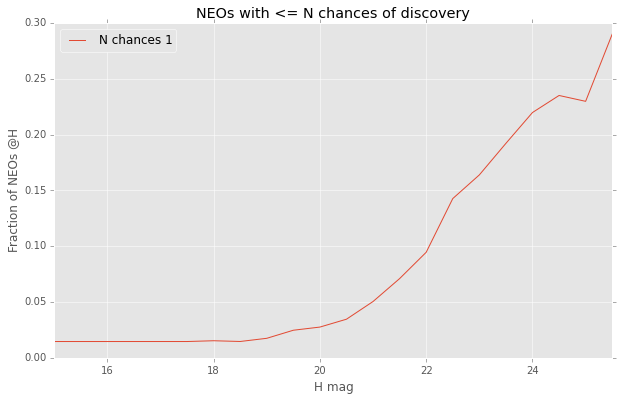

In [14]:
# Plot the fraction of objects with only X discovery chances, in year 12 of survey in standard discovery.
b = discbundles[12]
Hrange = mos.Hrange
nchances = np.arange(1, 2, 1)
mVals = b.metricValues.swapaxes(0, 1).filled(0)
for n in nchances:
    fraction = np.zeros(len(Hrange), float)
    for i, (H, mVal) in enumerate(zip(Hrange, mVals)):  
        match = np.where(mVal>0)
        n_available = float(len(match[0]))
        fraction[i] = len(np.where(mVal[match]<=n)[0]) / n_available
    plt.plot(Hrange, fraction, label='N chances %d' %(n))
plt.legend(loc='upper left', fancybox=True)
#plt.ylim(0, 5)
plt.xlim(15, Hrange.max())
plt.xlabel('H mag')
plt.ylabel('Fraction of NEOs @H')
plt.title('NEOs with <= N chances of discovery')

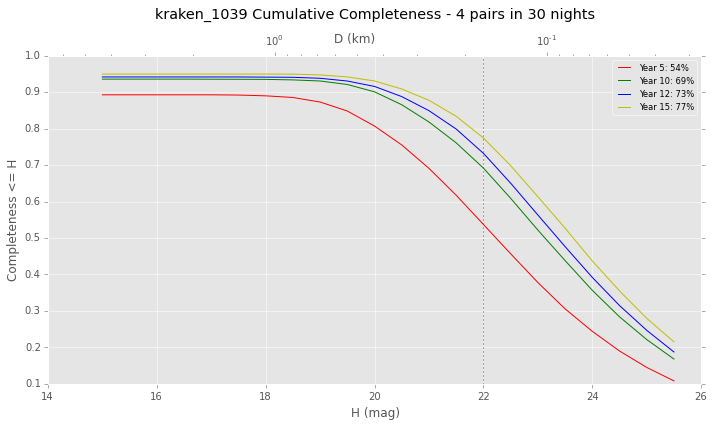

In [15]:
# Cumulative completeness, as function of H (for each of nyear above) -- requiring 4 pairs in 20 nights.
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = extrapairbundles[yr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Cumulative Completeness - 4 pairs in 30 nights' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')

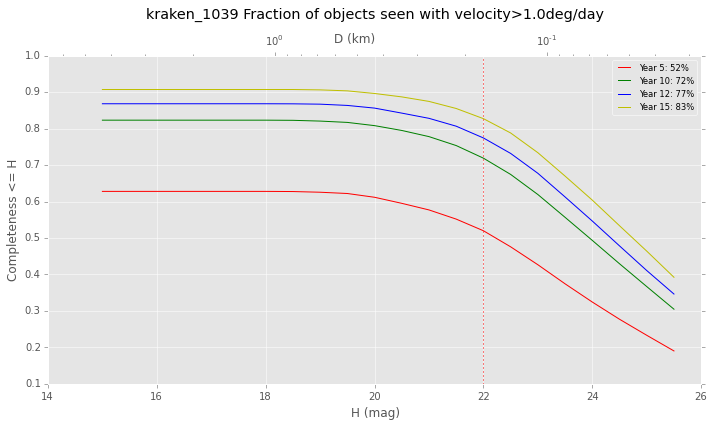

In [16]:
# Cumulative completeness - discovery with 'high' velocity.
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = velocitybundles[yr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Fraction of objects seen with velocity>1.0deg/day' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')


In [17]:
# Fraction found with high velocity but not found with 'discovery'. 
# TBD. Should be able to take metricValues from discbundles and match against metricValues from highVelocity.

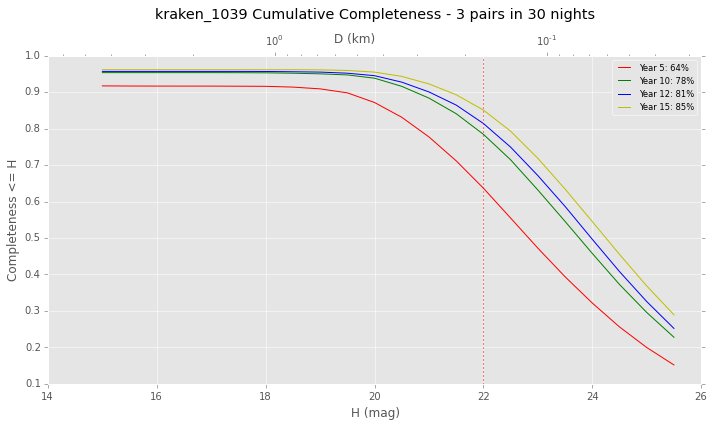

In [18]:
# Cumulative completeness, as function of H (for each of nyear above) -- requiring 3 pairs in 30 nights.
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = longdiscbundles[yr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Cumulative Completeness - 3 pairs in 30 nights' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')

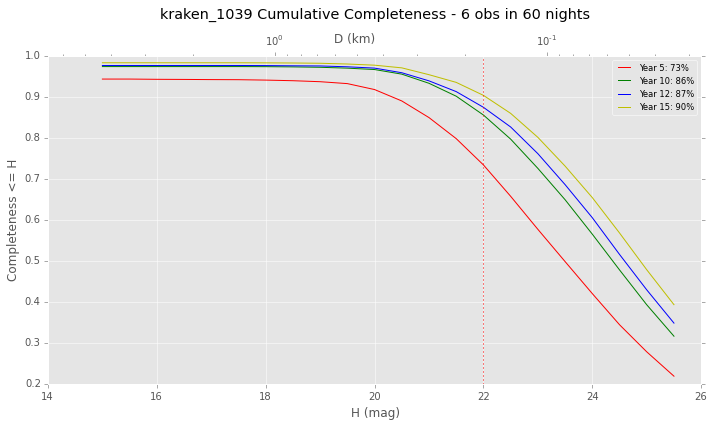

In [19]:
# Cumulative completeness, as function of H (for each of nyear above) -- with Mario's magic discovery software.
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for yr in nyears:
    completeness = magicbundles[yr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'Year %d: %.0f%s' %(yr, cval*100, '%'), 
                'color':yearColors[yr], 
                'title':'%s Cumulative Completeness - 6 obs in 60 nights' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')

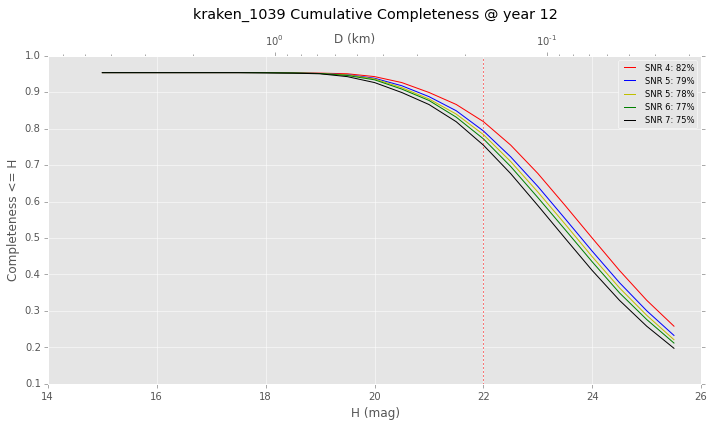

In [20]:
# Cumulative completeness as we vary SNR required for discovery.
compbundles = []

Hmark = 22
Hidx = np.where(mos.Hrange == Hmark)[0]

for snr in snrList:
    completeness = snrbundles[snr].summaryValues['CumulativeCompleteness'][0]
    completenessma = ma.MaskedArray(data=completeness, mask=False, fill=0)
    cval = completeness[Hidx]
    plotDict = {'albedo':0.07, 'label':'SNR %d: %.0f%s' %(snr, cval*100, '%'), 
                'color':snrColors[snr], 
                'title':'%s Cumulative Completeness @ year 12' %(runName), 'ylabel':'Completeness <= H'}
    mb = mmb.MoMetricBundle(ms.CompletenessMetric(), slicer=mos, constraint=discbundles[yr].constraint,
                            metadata=discbundles[yr].metadata, plotDict=plotDict)
    mb.metricValues = completenessma
    compbundles.append(mb)
ph.setMetricBundles(compbundles)
ph.plot(plotFunc=moPlots.MetricVsH())
plt.axvline(x=22, color='r', linestyle=':')